# **Importing the Brain Tumor Dataset**

In [ ]:
import kagglehub

path = kagglehub.dataset_download("leaderandpiller/brain-tumor-segmentation")
print("Downloaded dataset to:", path)

import shutil
import os

destination = "/content/data/brain_tumor_segmentation"
os.makedirs(destination, exist_ok=True)

# Copy files from cache to desired location
shutil.copytree(path, destination, dirs_exist_ok=True)

print("Dataset copied to:", destination)

Downloaded dataset to: /kaggle/input/brain-tumor-segmentation
Dataset copied to: /content/data/brain_tumor_segmentation


# **AlexNet Model without compression**

In [115]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import torch.backends.cudnn as cudnn

In [116]:
cudnn.benchmark = True

NUM_CLASSES = 2
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_WORKERS = 4  # Number of workers for data loading
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "/content/data/brain_tumor_segmentation"

In [117]:
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    torch.cuda.empty_cache()
    torch.cuda.memory.set_per_process_memory_fraction(0.9)

Using GPU: Tesla T4
GPU Memory: 14.74 GB


In [141]:
class AlexNetOriginal(nn.Module):
    def __init__(self):  # 1000 classes for ImageNet-style output
        super(AlexNetOriginal, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        dummy_input = torch.randn(1, 3, 227, 227) # Create a dummy input tensor with the expected shape
        with torch.no_grad():
            output_features = self.features(dummy_input) # Pass the dummy input through the features layers
        output_features_size = output_features.view(-1).shape[0]

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_features_size, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, 1000)             # Softmax for probabilities
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [127]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.images, self.labels = [], []

        # Updated to handle the specific directory structure
        for label, class_name in enumerate(['NO', 'YES']):
            folder = os.path.join(root_dir, f'{class_name}-20200502T082251Z-001', class_name)
            if not os.path.exists(folder):
                folder = os.path.join(root_dir, f'{class_name}-20200502T075011Z-001', class_name)

            if os.path.exists(folder):
                for img_name in os.listdir(folder):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(folder, img_name))
                        self.labels.append(label)
                print(f"Found {len([f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))])} images in {class_name} class")
            else:
                print(f"Warning: Folder not found for class '{class_name}' at {folder}")

        print(f"Found total of {len(self.images)} images in the dataset.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [128]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Initialize dataset
dataset = BrainTumorDataset(DATA_PATH, transform=transform)
print(f"Total images found: {len(dataset)}")

if len(dataset) == 0:
    raise RuntimeError("Dataset is empty. Check the folder path and content.")

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Dataloader safe setup
try:
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True  # Consider disabling in Colab
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )

except Exception as e:
    print("⚠️ Error using multiple workers, falling back to single-threaded loading.")
    print(f"Error details: {e}")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Found 6159 images in NO class
Found 5504 images in YES class
Found total of 11663 images in the dataset.
Total images found: 11663


In [129]:
def train(model, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), 100 * correct / total

In [130]:
def evaluate(model, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds += preds.cpu().tolist()
            all_labels += labels.cpu().tolist()

    return total_loss / len(val_loader), 100 * correct / total, all_preds, all_labels


In [131]:
def calculate_class_weights(dataset):
    class_counts = [0] * NUM_CLASSES
    for _, label in dataset:
        class_counts[label] += 1
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
    return torch.FloatTensor(class_weights)


In [142]:
model = AlexNetOriginal().to(DEVICE)
class_weights = calculate_class_weights(dataset)
criterion = nn.CrossEntropyLoss()  # no weight for 1000-class model
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0

print("\nStarting training...")
print(f"Class weights: {class_weights.tolist()}")

for epoch in range(NUM_EPOCHS):
    t_loss, t_acc = train(model, criterion, optimizer)
    v_loss, v_acc, preds, labels = evaluate(model, criterion)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accs.append(t_acc)
    val_accs.append(v_acc)

    if v_acc > best_val_acc:
        best_val_acc = v_acc
        torch.save(model.state_dict(), 'best_alexnet_model.pth')

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {t_loss:.4f}, Acc: {t_acc:.2f}% | Val Loss: {v_loss:.4f}, Acc: {v_acc:.2f}%")


Starting training...
Class weights: [0.9468258023262024, 1.059502124786377]
Epoch 1/10 | Train Loss: 4.7580, Acc: 44.12% | Val Loss: 0.7173, Acc: 59.02%
Epoch 2/10 | Train Loss: 0.7569, Acc: 52.60% | Val Loss: 0.7003, Acc: 53.15%
Epoch 3/10 | Train Loss: 0.6882, Acc: 53.98% | Val Loss: 0.6866, Acc: 69.40%
Epoch 4/10 | Train Loss: 0.6834, Acc: 55.63% | Val Loss: 0.6819, Acc: 69.74%
Epoch 5/10 | Train Loss: 0.6839, Acc: 56.63% | Val Loss: 0.6769, Acc: 59.67%
Epoch 6/10 | Train Loss: 0.6701, Acc: 59.42% | Val Loss: 0.7006, Acc: 46.81%
Epoch 7/10 | Train Loss: 0.6686, Acc: 59.14% | Val Loss: 0.6358, Acc: 71.45%
Epoch 8/10 | Train Loss: 0.6601, Acc: 61.33% | Val Loss: 0.6346, Acc: 72.82%
Epoch 9/10 | Train Loss: 0.6409, Acc: 64.16% | Val Loss: 0.5906, Acc: 74.07%
Epoch 10/10 | Train Loss: 0.6071, Acc: 67.87% | Val Loss: 0.5459, Acc: 74.24%


In [143]:
print("\nClassification Report:\n", classification_report(labels, preds))
print("Confusion Matrix:\n", confusion_matrix(labels, preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.86      0.78      1240
           1       0.79      0.61      0.69      1093

    accuracy                           0.74      2333
   macro avg       0.75      0.73      0.73      2333
weighted avg       0.75      0.74      0.74      2333

Confusion Matrix:
 [[1069  171]
 [ 430  663]]


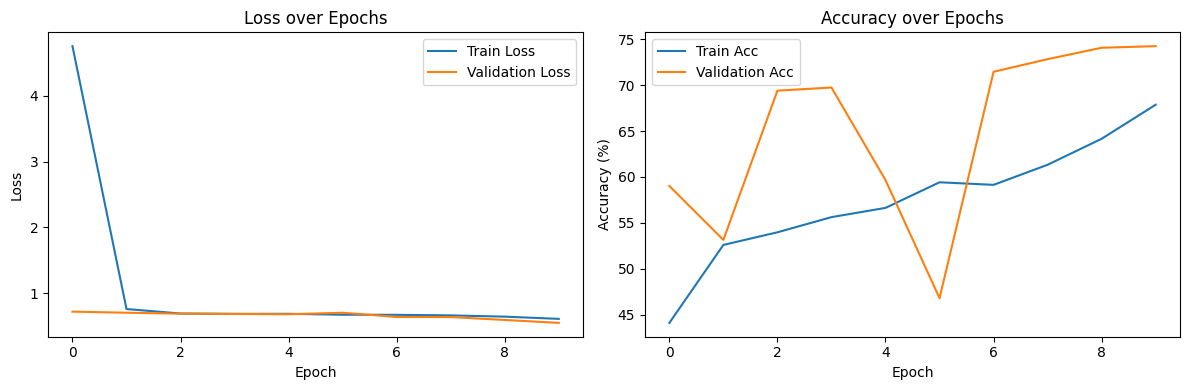

In [144]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.savefig("alexnet_training_metrics.png")
plt.show()

In [149]:
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")

avg_val_acc = sum(val_accs) / len(val_accs)
print(f"Average Validation Accuracy: {avg_val_acc:.2f}%")


Final Validation Accuracy: 74.24%
Average Validation Accuracy: 65.04%
